# 5. Calculting wastewater quality

The core functionality of pySIMDEUM is to deliver consumption, and if required, discharge water profiles for houses. However, some optional post-processing analysis is available for the user to calculate wastewater quality. This includes:

* Nutrient concentrations
    * n
    * p
    * cod
    * bod5
    * ss
    * amm
* Discharge temperature
    * Note that this is at the point when it leaves the end use. In reality, temperature changes over time so this figure may not represent the exact temperatures.

## Nutrient concentrations

In [ ]:
import pysimdeum
import matplotlib.pyplot as plt
import os
import toml

from pysimdeum.data import DATA_DIR
import pysimdeum.utils.wastewater_quality as wq

Some default statistics for nutrient concentrations are provided in the `NL` and `UK` data folders in `ww_nutrients.toml`. The statistics are provided in `g/use`. This is an important point as pysimdeum allow for the inclusion of different enduse subtypes - an example being a more water efficient toilet. The amount of urine deposited will not change as a result but due to the water usage, nutrient concentration will. As a result, it makes sense to input data as per use, with the actualy concentration in the water being calculated by pysimdeum.

The nutrient concentration config file is structured as below, listed by `enduse` with nested data by `substype` (if subtypes are included for that `enduse`)

In [6]:
nutrient_data = toml.load(os.path.join(DATA_DIR, "NL", 'ww_nutrients.toml'))
nutrient_data

{'Shower': {'shower': {'n': 0.49,
   'p': 0.07,
   'cod': 13.93,
   'bod5': 7.43,
   'ss': 13.93,
   'amm': 0.06}},
 'Bathtub': {'bathtub': {'n': 0.85,
   'p': 0.15,
   'cod': 26.05,
   'bod5': 15.07,
   'ss': 7.79,
   'amm': 0.12}},
 'Wc': {'urine': {'n': 2.0,
   'p': 0.23,
   'cod': 2.0,
   'bod5': 2.46,
   'ss': 0.0,
   'amm': 0.92},
  'faeces': {'n': 3.09,
   'p': 0.48,
   'cod': 30.23,
   'bod5': 12.03,
   'ss': 3.04,
   'amm': 1.1}},
 'KitchenTap': {'consumption': {'n': 0,
   'p': 0,
   'cod': 0,
   'bod5': 0,
   'ss': 0,
   'amm': 0},
  'dishes': {'n': 0.35,
   'p': 0.28,
   'cod': 7.51,
   'bod5': 4.48,
   'ss': 4.68,
   'amm': 0.03},
  'washing_hands': {'n': 0.35,
   'p': 0.28,
   'cod': 7.51,
   'bod5': 4.48,
   'ss': 4.68,
   'amm': 0.03},
  'other': {'n': 0.35,
   'p': 0.28,
   'cod': 7.51,
   'bod5': 4.48,
   'ss': 4.68,
   'amm': 0.03}},
 'BathroomTap': {'washing_shaving': {'n': 0.04,
   'p': 0.14,
   'cod': 1.5,
   'bod5': 0.81,
   'ss': 0.35,
   'amm': 0.002},
  'brushi

As always, initialise your household.

In [ ]:
# Build a house (two-person household)
house = pysimdeum.built_house(house_type='one_person', duration ='1 day', simulate_discharge=True)

/Users/val.ismaili/DAA/pysimdeum/pysimdeum/core/utils.py:287: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  s.iloc[start:end] = intensity
/Users/val.ismaili/DAA/pysimdeum/pysimdeum/core/utils.py:343: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6723566666666668' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  discharge_pattern.loc[discharge_start:discharge_end - pd.Timedelta(seconds=1)] = discharge_rate # restrict range to not be inclusive of final timstamp as this would result in extra discharge
/Users/val.ismaili/DAA/pysimdeum/pysimdeum/core/utils.py:343: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '

Nutrient concentration is calculated post-simulation and can be thought of as a stage of post-processing analysis. The calculation only requires the `discharge` `xarray.Dataset` that is generated when building a house and specifying to `simulate_discharge`. The `country` argument defaults to `NL`, can be optionally switched to `UK`. `time_agg` is the level of temporal aggregation you want your resulting nutrient concentration profile to be aggregated to, defaults to hourly. Options include:

* `s`: seconds
* `m`: minutes
* `15min`: 15-minute intervals
* `30min`: 30-minute intervals
* `h`: hourly (default)

The calculation is simple. For each `discharge_event` the sampled nutrient concentration for the `enduse` and `nutrient` is divided by the total discharge volume for that event.

$$ \text{Nutrient Concentration (g/L)} = \frac{\text{Nutrient per Use}}{\text{Total Flow}} $$

When temporally aggregating to household level, its effectively a weighted average as the nutrient concentration (g/L) is multiplied by the flow at that timestamp, for each enduse. These are summated and then weighted against the total discharge flow of the household at that timestamp. If temporal aggregation greater than a second is chosen, values for each of the timestamps will be summated:

$$ \text{Weighted Average} = \frac{\sum (\text{Flow} \cdot \text{Nutrient Concentration})}{\sum \text{Flow}} $$

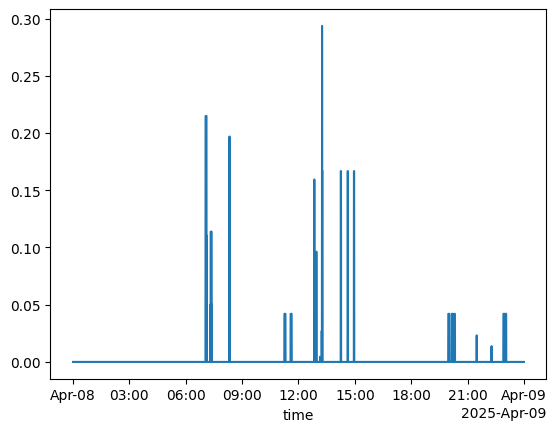

In [ ]:
nutrients_df = wq.hh_discharge_nutrients(discharge, country='NL', time_agg='h')
nutrients_df.head()

## Discharge temperature

The process is very similar for calculating the temperature of wastewater. Each `enduse` has a `discharge_temperature` provided within the enduse statistics config file. The calculation when aggregating to household level is quite simple and essentially involves weighting the `discharge_temperature` based on the ratio of wastewater flow that `enduse` is contributing to the total wastewater flow at that given timestamp across all enduses.

The formula for temperature calculation is:

$$
T = \frac{(F_1 \cdot T_1) + (F_2 \cdot T_2)}{F_1 + F_2}
$$

* $T$ is the calculated temperature.
* $F_1$ and $F_2$ are the flows for enduse1 and enduse2.
* $T_1$ and $T_2$ are the `discharge_temperature` for enduse1 and enduse2.

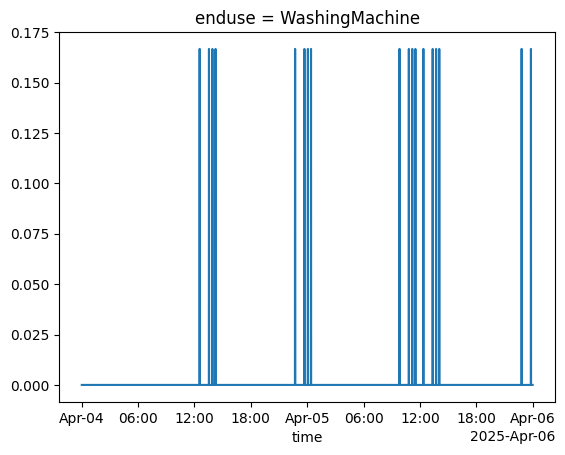

In [ ]:
temp_df = wq.hh_discharge_temperature(discharge, country='NL', time_agg='h')
temp_df.head()